In [1]:
#for data processing
import numpy as np 
import pandas as pd

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import seaborn as sns
from collections import Counter
sns.set_style('whitegrid')
#plt.rcParams['figure.figsize'] = (12, 10)
# https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlib

In [3]:
train= pd.read_csv("train.csv")
test= pd.read_csv("test.csv")

In [4]:
train.head(2)

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1


In [5]:
test.head(2)

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
0,F00000002,188,1,1,1,0,NaN,0,2
1,F00000007,410,1,1,1,0,0.0,0,2


In [6]:
train['train_or_test']='train'
test['train_or_test']='test'
all=pd.concat([train,test])

In [7]:
all.head(2)

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_or_test
0,F00000001,188,1,0,1,0,0.0,0,1,0.0,train
1,F00000003,209,1,0,1,0,0.0,0,2,1.0,train


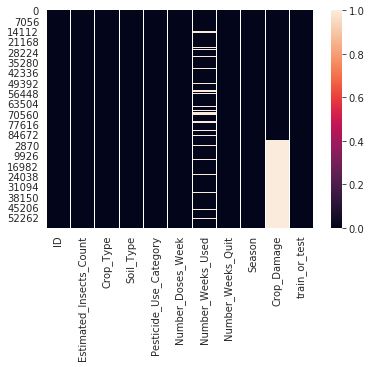

In [8]:
#Visualization to check for missing values
sns.heatmap(all.isna())

### Exploratory Data Analysis

Target variable: Crop Damage (0,1,2), Potential Predictors: All Others

#### Univariate Analysis

In [9]:
all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148168 entries, 0 to 59309
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       148168 non-null  object 
 1   Estimated_Insects_Count  148168 non-null  int64  
 2   Crop_Type                148168 non-null  int64  
 3   Soil_Type                148168 non-null  int64  
 4   Pesticide_Use_Category   148168 non-null  int64  
 5   Number_Doses_Week        148168 non-null  int64  
 6   Number_Weeks_Used        133275 non-null  float64
 7   Number_Weeks_Quit        148168 non-null  int64  
 8   Season                   148168 non-null  int64  
 9   Crop_Damage              88858 non-null   float64
 10  train_or_test            148168 non-null  object 
dtypes: float64(2), int64(7), object(2)
memory usage: 13.6+ MB


In [10]:
#ID
sum(all['ID'].value_counts()>1)

0

All unique ids

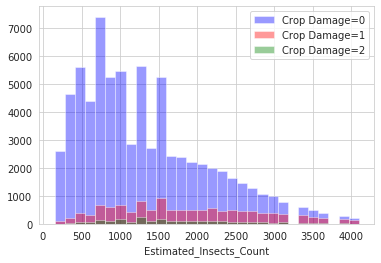

In [11]:
#Estimated_Insects_Count
sns.set_style('whitegrid')
sns.distplot(all[all['Crop_Damage']==0]['Estimated_Insects_Count'],bins=30,color='blue',kde=False)
sns.distplot(all[all['Crop_Damage']==1]['Estimated_Insects_Count'],bins=30,color='red',kde=False)
sns.distplot(all[all['Crop_Damage']==2]['Estimated_Insects_Count'],bins=30,color='green',kde=False)
plt.legend(labels=['Crop Damage=0', 'Crop Damage=1', 'Crop Damage=2'])

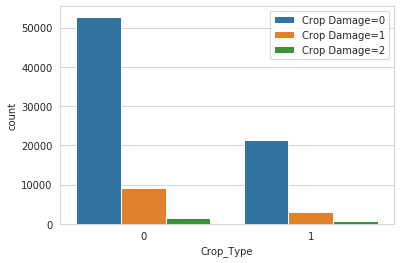

In [12]:
#Crop_Type
sns.set_style('whitegrid')
sns.countplot(x='Crop_Type',data=all,hue='Crop_Damage')
plt.legend(labels=['Crop Damage=0', 'Crop Damage=1', 'Crop Damage=2'])

In [13]:
groupby_df = all[all['train_or_test']=='train'].groupby(['Crop_Type', 'Crop_Damage']).agg({'Crop_Damage': 'count'})
groupby_pcts = groupby_df.groupby(level=0).apply(lambda x:round(100 * x / x.sum(),2))
groupby_df,groupby_pcts

(                       Crop_Damage
 Crop_Type Crop_Damage             
 0         0.0                52778
           1.0                 9204
           2.0                 1607
 1         0.0                21460
           1.0                 3103
           2.0                  706,
                        Crop_Damage
 Crop_Type Crop_Damage             
 0         0.0                83.00
           1.0                14.47
           2.0                 2.53
 1         0.0                84.93
           1.0                12.28
           2.0                 2.79)

Crop Type 1 has slightly higher survival %

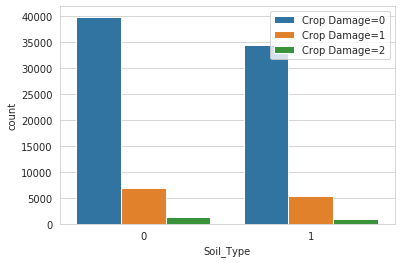

In [14]:
#Soil_Type
sns.set_style('whitegrid')
sns.countplot(x='Soil_Type',data=all,hue='Crop_Damage')
plt.legend(labels=['Crop Damage=0', 'Crop Damage=1', 'Crop Damage=2'])

In [15]:
groupby_df = all[all['train_or_test']=='train'].groupby(['Soil_Type', 'Crop_Damage']).agg({'Crop_Damage': 'count'})
groupby_pcts = groupby_df.groupby(level=0).apply(lambda x:round(100 * x / x.sum(),2))
groupby_df,groupby_pcts

(                       Crop_Damage
 Soil_Type Crop_Damage             
 0         0.0                39841
           1.0                 6953
           2.0                 1330
 1         0.0                34397
           1.0                 5354
           2.0                  983,
                        Crop_Damage
 Soil_Type Crop_Damage             
 0         0.0                82.79
           1.0                14.45
           2.0                 2.76
 1         0.0                84.44
           1.0                13.14
           2.0                 2.41)

Soil Type 1 has slightly higher survival %

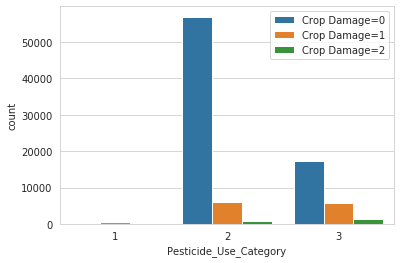

In [16]:
#Pesticide_Use_Category
sns.set_style('whitegrid')
sns.set_style('whitegrid')
sns.countplot(x='Pesticide_Use_Category',data=all,hue='Crop_Damage')
plt.legend(labels=['Crop Damage=0', 'Crop Damage=1', 'Crop Damage=2'])

In [17]:
groupby_df = all[all['train_or_test']=='train'].groupby(['Pesticide_Use_Category', 'Crop_Damage']).agg({'Crop_Damage': 'count'})
groupby_pcts = groupby_df.groupby(level=0).apply(lambda x:round(100 * x / x.sum(),2))
groupby_df,groupby_pcts

(                                    Crop_Damage
 Pesticide_Use_Category Crop_Damage             
 1                      0.0                  118
                        1.0                  554
                        2.0                  165
 2                      0.0                56958
                        1.0                 6072
                        2.0                  679
 3                      0.0                17162
                        1.0                 5681
                        2.0                 1469,
                                     Crop_Damage
 Pesticide_Use_Category Crop_Damage             
 1                      0.0                14.10
                        1.0                66.19
                        2.0                19.71
 2                      0.0                89.40
                        1.0                 9.53
                        2.0                 1.07
 3                      0.0                70.59
                   

Pesticide Use Category 2 i.e. previously used has higher survival %

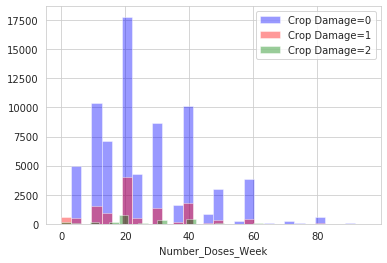

In [18]:
#Number_Doses_Week
sns.set_style('whitegrid')
sns.distplot(all[all['Crop_Damage']==0]['Number_Doses_Week'],bins=30,color='blue',kde=False)
sns.distplot(all[all['Crop_Damage']==1]['Number_Doses_Week'],bins=30,color='red',kde=False)
sns.distplot(all[all['Crop_Damage']==2]['Number_Doses_Week'],bins=30,color='green',kde=False)
plt.legend(labels=['Crop Damage=0', 'Crop Damage=1', 'Crop Damage=2'])

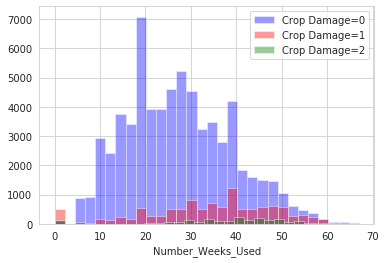

In [19]:
#Number_Weeks_Used
sns.set_style('whitegrid')
sns.distplot(all[all['Crop_Damage']==0]['Number_Weeks_Used'],bins=30,color='blue',kde=False)
sns.distplot(all[all['Crop_Damage']==1]['Number_Weeks_Used'],bins=30,color='red',kde=False)
sns.distplot(all[all['Crop_Damage']==2]['Number_Weeks_Used'],bins=30,color='green',kde=False)
plt.legend(labels=['Crop Damage=0', 'Crop Damage=1', 'Crop Damage=2'])

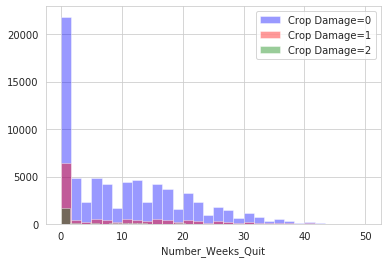

In [20]:
#Number_Weeks_Quit
sns.set_style('whitegrid')
sns.distplot(all[all['Crop_Damage']==0]['Number_Weeks_Quit'],bins=30,color='blue',kde=False)
sns.distplot(all[all['Crop_Damage']==1]['Number_Weeks_Quit'],bins=30,color='red',kde=False)
sns.distplot(all[all['Crop_Damage']==2]['Number_Weeks_Quit'],bins=30,color='green',kde=False)
plt.legend(labels=['Crop Damage=0', 'Crop Damage=1', 'Crop Damage=2'])

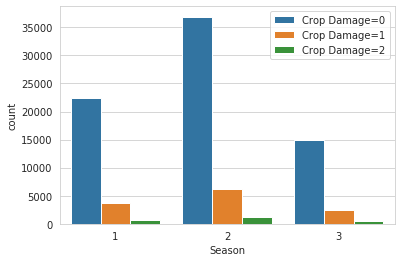

In [21]:
#Pesticide_Use_Category
sns.set_style('whitegrid')
sns.set_style('whitegrid')
sns.countplot(x='Season',data=all,hue='Crop_Damage')
plt.legend(labels=['Crop Damage=0', 'Crop Damage=1', 'Crop Damage=2'])

In [22]:
groupby_df = all[all['train_or_test']=='train'].groupby(['Season', 'Crop_Damage']).agg({'Crop_Damage': 'count'})
groupby_pcts = groupby_df.groupby(level=0).apply(lambda x:round(100 * x / x.sum(),2))
groupby_df,groupby_pcts

(                    Crop_Damage
 Season Crop_Damage             
 1      0.0                22493
        1.0                 3748
        2.0                  661
 2      0.0                36881
        1.0                 6115
        2.0                 1214
 3      0.0                14864
        1.0                 2444
        2.0                  438,
                     Crop_Damage
 Season Crop_Damage             
 1      0.0                83.61
        1.0                13.93
        2.0                 2.46
 2      0.0                83.42
        1.0                13.83
        2.0                 2.75
 3      0.0                83.76
        1.0                13.77
        2.0                 2.47)

No difference between seasons in survival %

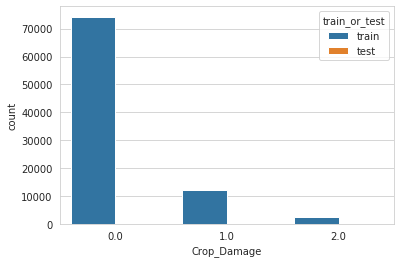

In [23]:
#Crop_Damage
sns.set_style('whitegrid')
sns.countplot('Crop_Damage',hue='train_or_test',data=all)

#### Bivariate Analysis

In [24]:
all.dtypes

ID                          object
Estimated_Insects_Count      int64
Crop_Type                    int64
Soil_Type                    int64
Pesticide_Use_Category       int64
Number_Doses_Week            int64
Number_Weeks_Used          float64
Number_Weeks_Quit            int64
Season                       int64
Crop_Damage                float64
train_or_test               object
dtype: object

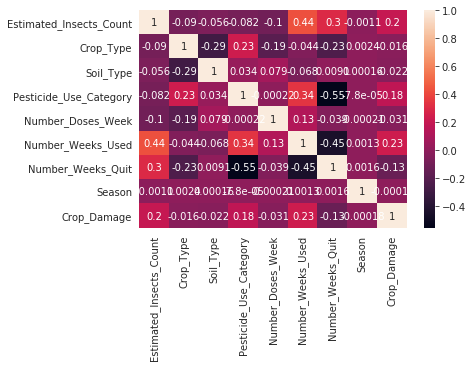

In [25]:
sns.heatmap(all.corr(),annot=True)

Number of Weeks Use has good correlation with Estimated_Insects_Count - can be used for imputing missing values 

##### Continuous and Continuous

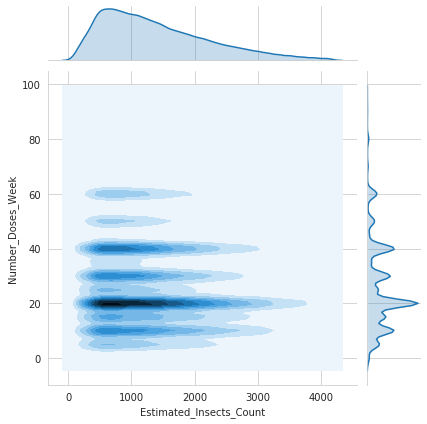

In [26]:
# Estimated_Insects_Count & Number_Doses_Week  
sns.jointplot(x='Estimated_Insects_Count',y='Number_Doses_Week',data=all,kind='kde')

20 doses per week and 0-2000 Insect Count is most common

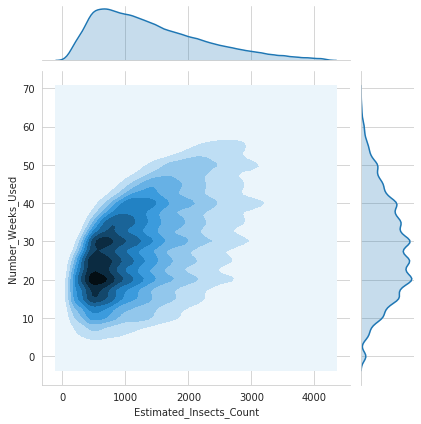

In [27]:
# Estimated_Insects_Count & Number_Weeks_Used
sns.jointplot(x='Estimated_Insects_Count',y='Number_Weeks_Used',data=all,kind='kde')

10-30 weeks for 0-1000 Insect Count and increased usage with higher insect count

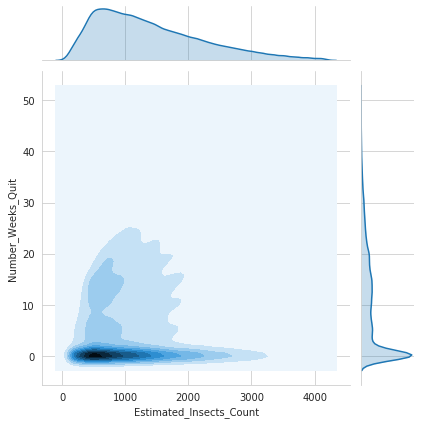

In [28]:
# Estimated_Insects_Count & Number_Weeks_Quit
sns.jointplot(x='Estimated_Insects_Count',y='Number_Weeks_Quit',data=all,kind='kde')

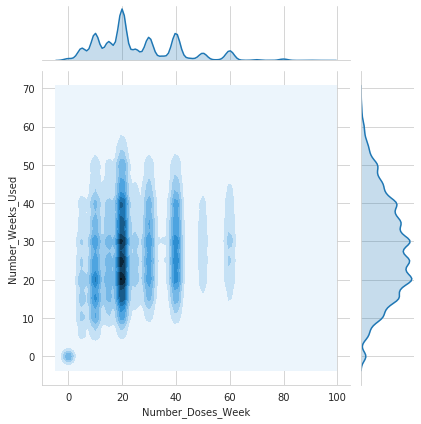

In [29]:
# Number_Doses_Week & Number_Weeks_Used
sns.jointplot(x='Number_Doses_Week',y='Number_Weeks_Used',data=all,kind='kde')

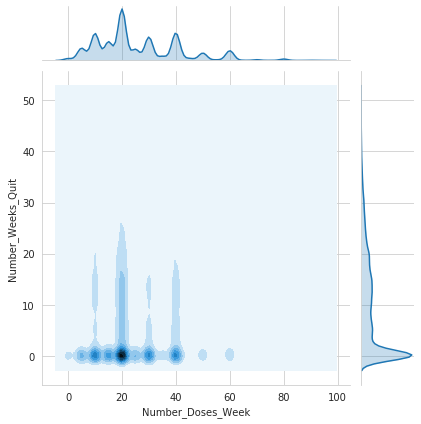

In [30]:
# Number_Doses_Week & Number_Weeks_Quit
sns.jointplot(x='Number_Doses_Week',y='Number_Weeks_Quit',data=all,kind='kde')

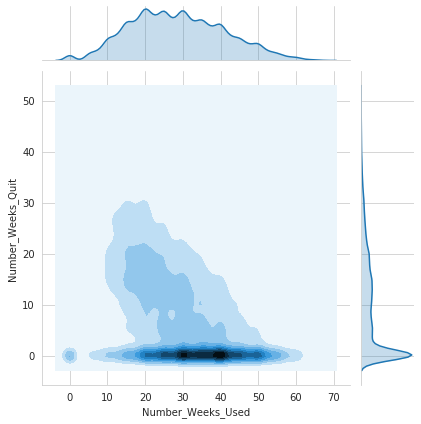

In [31]:
# Number_Weeks_Used & Number_Weeks_Quit
sns.jointplot(x='Number_Weeks_Used',y='Number_Weeks_Quit',data=all,kind='kde')

##### Categorical & Categorical

In [32]:
from scipy.stats import chi2

In [33]:
def chi_test(df,col1,col2):
    
    #Contingency Table
    contingency_table=pd.crosstab(df[col1],df[col2])
    #print('contingency_table :-\n',contingency_table)

    #Observed Values
    Observed_Values = contingency_table.values 
    #print("\nObserved Values :-\n",Observed_Values)

    #Expected Values
    import scipy.stats
    b=scipy.stats.chi2_contingency(contingency_table)
    Expected_Values = b[3]
    #print("\nExpected Values :-\n",Expected_Values)

    #Degree of Freedom
    no_of_rows=len(contingency_table.iloc[0:2,0])
    no_of_columns=len(contingency_table.iloc[0,0:2])
    df=(no_of_rows-1)*(no_of_columns-1)
    #print("\nDegree of Freedom:-",df)

    #Significance Level 5%
    alpha=0.05
    #print('\nSignificance level: ',alpha)

    #chi-square statistic - χ2
    chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
    chi_square_statistic=chi_square[0]+chi_square[1]
    #print("\nchi-square statistic:-",chi_square_statistic)

    #critical_value
    critical_value=chi2.ppf(q=1-alpha,df=df)
    #print('\ncritical_value:',critical_value)

    #p-value
    p_value=1-chi2.cdf(x=chi_square_statistic,df=df)
    #print('\np-value:',p_value)

    #compare chi_square_statistic with critical_value and p-value which is the probability of getting chi-square>0.09 (chi_square_statistic)
    if chi_square_statistic>=critical_value:
        print("\nchi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.")
    else:
        print("\nchi_square_statistic & critical_value - not significant result, fail to reject null hypothesis (H0), independent.")

    if p_value<=alpha:
        print("\np_value & alpha - significant result, reject null hypothesis (H0), dependent.")
    else:
        print("\np_value & alpha - not significant result, fail to reject null hypothesis (H0), independent.")

In [35]:
#Soil_Type & Crop_Type
chi_test(all,'Soil_Type','Crop_Type')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


In [36]:
#Soil_Type & Pesticide_Use_Category
chi_test(all,'Soil_Type','Pesticide_Use_Category')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


In [39]:
#Soil_Type & Season
chi_test(all,'Soil_Type','Season')


chi_square_statistic & critical_value - not significant result, fail to reject null hypothesis (H0), independent.

p_value & alpha - not significant result, fail to reject null hypothesis (H0), independent.


In [40]:
#Crop_Type & Pesticide_Use_Category
chi_test(all,'Crop_Type','Pesticide_Use_Category')


chi_square_statistic & critical_value - significant result, reject null hypothesis (H0), dependent.

p_value & alpha - significant result, reject null hypothesis (H0), dependent.


In [41]:
#Crop_Type & Season
chi_test(all,'Crop_Type','Season')


chi_square_statistic & critical_value - not significant result, fail to reject null hypothesis (H0), independent.

p_value & alpha - not significant result, fail to reject null hypothesis (H0), independent.


In [42]:
#Pesticide_Use_Category & Season
chi_test(all,'Pesticide_Use_Category','Season')


chi_square_statistic & critical_value - not significant result, fail to reject null hypothesis (H0), independent.

p_value & alpha - not significant result, fail to reject null hypothesis (H0), independent.


Season is independent of all categorical variables

##### Categorical & Continuous

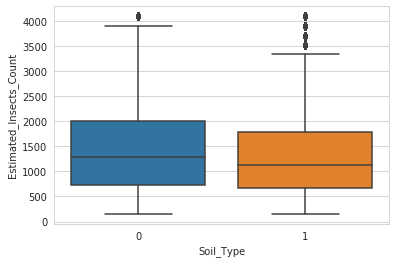

In [43]:
#Soil_Type & Estimated_Insects_Count
sns.boxplot(x='Soil_Type',y='Estimated_Insects_Count',data=all)

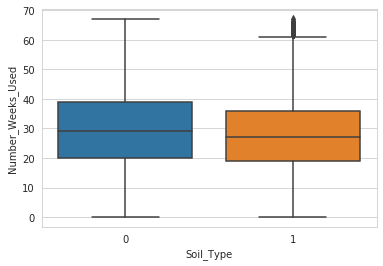

In [44]:
#Soil_Type & Number_Weeks_Used
sns.boxplot(x='Soil_Type',y='Number_Weeks_Used',data=all)

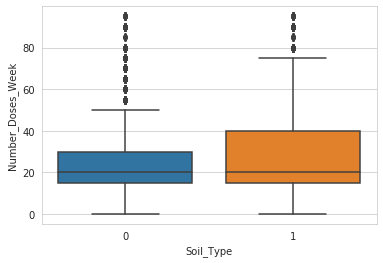

In [45]:
#Soil_Type & Number_Doses_Week
sns.boxplot(x='Soil_Type',y='Number_Doses_Week',data=all)

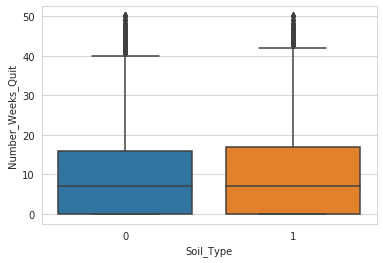

In [46]:
#Soil_Type & Number_Weeks_Quit
sns.boxplot(x='Soil_Type',y='Number_Weeks_Quit',data=all)

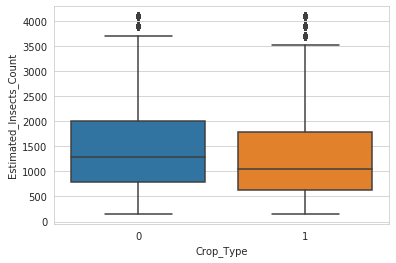

In [47]:
#Crop_Type & Estimated_Insects_Count
sns.boxplot(x='Crop_Type',y='Estimated_Insects_Count',data=all)

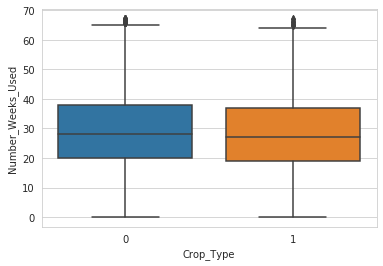

In [48]:
#Crop_Type & Number_Weeks_Used
sns.boxplot(x='Crop_Type',y='Number_Weeks_Used',data=all)

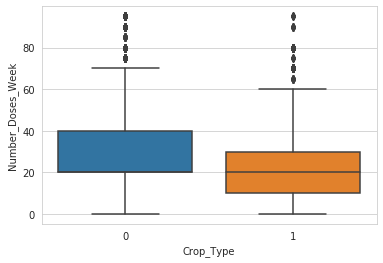

In [49]:
#Crop_Type & Number_Doses_Week
sns.boxplot(x='Crop_Type',y='Number_Doses_Week',data=all)

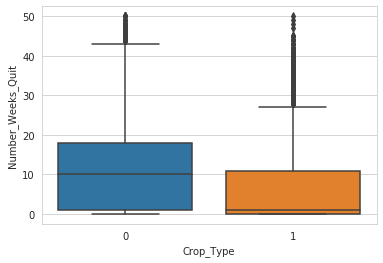

In [50]:
#Crop_Type & Number_Weeks_Quit
sns.boxplot(x='Crop_Type',y='Number_Weeks_Quit',data=all)

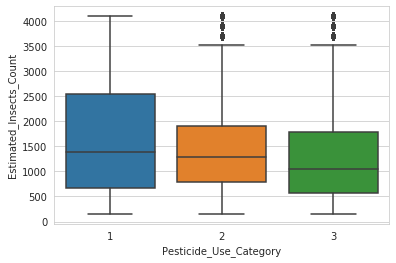

In [51]:
#Pesticide_Use_Category & Estimated_Insects_Count
sns.boxplot(x='Pesticide_Use_Category',y='Estimated_Insects_Count',data=all)

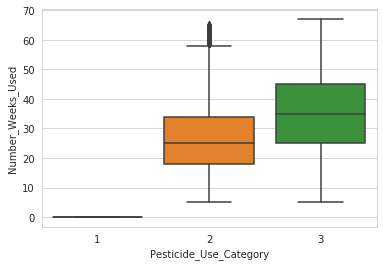

In [52]:
#Pesticide_Use_Category & Number_Weeks_Used
sns.boxplot(x='Pesticide_Use_Category',y='Number_Weeks_Used',data=all)

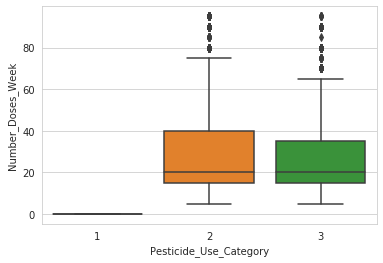

In [53]:
#Pesticide_Use_Category & Number_Doses_Week
sns.boxplot(x='Pesticide_Use_Category',y='Number_Doses_Week',data=all)

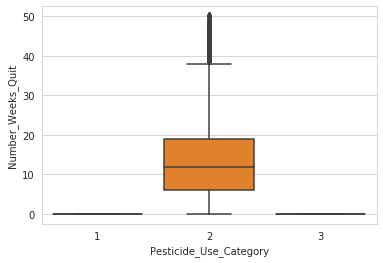

In [54]:
#Pesticide_Use_Category & Number_Weeks_Quit
sns.boxplot(x='Pesticide_Use_Category',y='Number_Weeks_Quit',data=all)

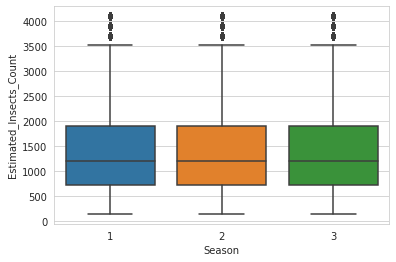

In [55]:
#Season & Estimated_Insects_Count
sns.boxplot(x='Season',y='Estimated_Insects_Count',data=all)

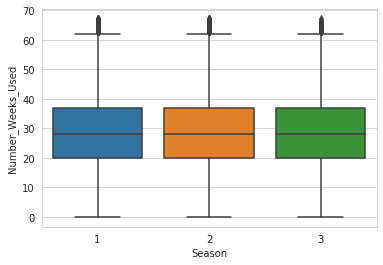

In [56]:
#Season & Number_Weeks_Used
sns.boxplot(x='Season',y='Number_Weeks_Used',data=all)

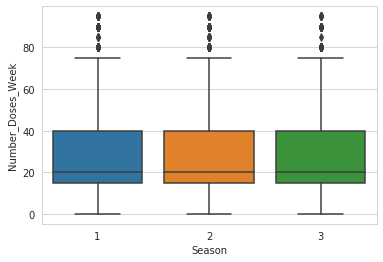

In [57]:
#Season & Number_Doses_Week
sns.boxplot(x='Season',y='Number_Doses_Week',data=all)

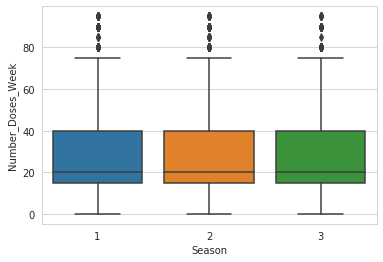

In [58]:
#Season & Number_Weeks_Quit
sns.boxplot(x='Season',y='Number_Doses_Week',data=all)

#### Feature Engineering

In [59]:
feature_cols = all.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('train_or_test')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season']


Stripping the 'F' for all IDs, this is required to sort the IDs

In [60]:
all['ID_value'] = all['ID'].apply(lambda x: x.strip('F')).astype('int')

In [61]:
all=all.sort_values(['ID_value'])

In [62]:
all.shape

(148168, 12)

Creating a dummy date range to check if the data is time series

In [63]:
#Performing this operation as datetime has an upper and lower limit
date = np.array('2020-07-24', dtype=np.datetime64)
date=date-74084
date

numpy.datetime64('1817-09-23')

In [64]:
#Creating a date array 
date_arr=date+np.arange(148168)
date_arr

array(['1817-09-23', '1817-09-24', '1817-09-25', ..., '2223-05-23',
       '2223-05-24', '2223-05-25'], dtype='datetime64[D]')

In [65]:
all['date']=date_arr#pd.to_datetime(date_arr, errors='coerce')

Checking if all continuous variables are time dependent

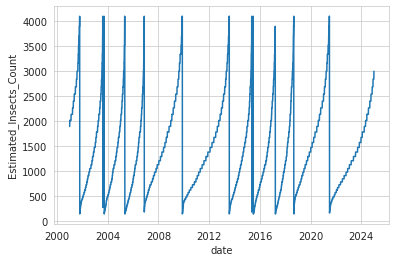

In [66]:
#Estimated_Insects_Count
sns.lineplot(x=all[(all['date'].dt.year>2000) & (all['date'].dt.year<2025)]['date'],y=all[(all['date'].dt.year>2000) & (all['date'].dt.year<2025)]['Estimated_Insects_Count'])

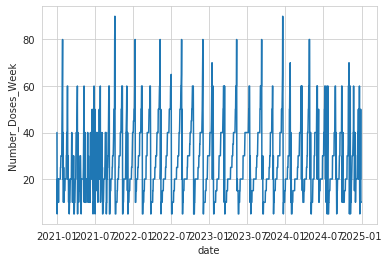

In [67]:
#Number_Doses_Week
sns.lineplot(x=all[(all['date'].dt.year>2020) & (all['date'].dt.year<2025)]['date'],y=all[(all['date'].dt.year>2020) & (all['date'].dt.year<2025)]['Number_Doses_Week'])

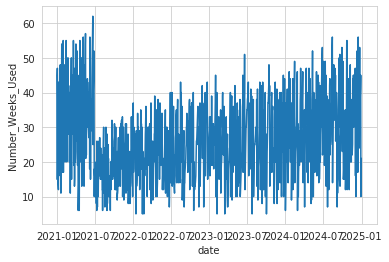

In [68]:
#Number_Weeks_Used
sns.lineplot(x=all[(all['date'].dt.year>2020) & (all['date'].dt.year<2025)]['date'],y=all[(all['date'].dt.year>2020) & (all['date'].dt.year<2025)]['Number_Weeks_Used'])

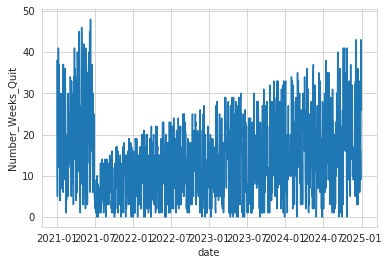

In [69]:
#SeasonNumber_Weeks_Quit
sns.lineplot(x=all[(all['date'].dt.year>2020) & (all['date'].dt.year<2025)]['date'],y=all[(all['date'].dt.year>2020) & (all['date'].dt.year<2025)]['Number_Weeks_Quit'])

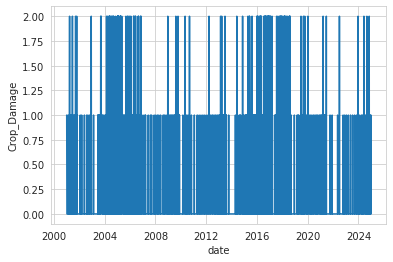

In [70]:
#Crop_Damage
sns.lineplot(x=all[(all['date'].dt.year>2000) & (all['date'].dt.year<2025)]['date'],y=all[(all['date'].dt.year>2000) & (all['date'].dt.year<2025)]['Crop_Damage'])

In [71]:
#Resetting Index
all=all.reset_index(drop=True)

Creating lag variables for Crop_Damage group by Categorical Variables

In [72]:
all['Crop_Type_Damage_lag1']=all.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x:x.shift().rolling(5,min_periods=1).mean()).fillna(-999).values
all['Soil_Type_Damage_lag1']=all.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x:x.shift().rolling(5,min_periods=1).mean()).fillna(-999).values
all['Pesticide_Use_Category_lag1']=all.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x:x.shift().rolling(5,min_periods=1).mean()).fillna(-999).values
all['Season_lag1']=all.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x:x.shift().rolling(5,min_periods=1).mean()).fillna(-999).values

all['Crop_Type_Damage_lag2']=all.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x:x.shift(periods=2).rolling(5,min_periods=1).mean()).fillna(-999).values
all['Soil_Type_Damage_lag2']=all.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x:x.shift(periods=2).rolling(5,min_periods=1).mean()).fillna(-999).values
all['Pesticide_Use_Category_lag2']=all.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x:x.shift(periods=2).rolling(5,min_periods=1).mean()).fillna(-999).values
all['Season_lag2']=all.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x:x.shift(periods=2).rolling(5,min_periods=1).mean()).fillna(-999).values


In [73]:
#Setting Crop_Damage=-999 for missing values
all.loc[all['train_or_test'] == 'test', 'Crop_Damage'] = -999

In [74]:
#Creating Other Lag Variables
all['Crop_Damage_lag1'] = all['Crop_Damage'].shift(fill_value=-999)
all['Estimated_Insects_Count_lag1'] = all['Estimated_Insects_Count'].shift(fill_value=-999)
all['Crop_Type_lag1'] = all['Crop_Type'].shift(fill_value=-999)
all['Soil_Type_lag1'] = all['Soil_Type'].shift(fill_value=-999)
all['Pesticide_Use_Category_lag1'] = all['Pesticide_Use_Category'].shift(fill_value=-999)
all['Number_Doses_Week_lag1'] = all['Number_Doses_Week'].shift(fill_value=-999)
all['Number_Weeks_Used_lag1'] = all['Number_Weeks_Used'].shift(fill_value=-999)
all['Number_Weeks_Quit_lag1'] = all['Number_Weeks_Quit'].shift(fill_value=-999)
all['Season_lag1'] = all['Season'].shift(fill_value=-999)

all['Crop_Damage_lag2'] = all['Crop_Damage'].shift(periods=2,fill_value=-999)
all['Estimated_Insects_Count_lag2'] = all['Estimated_Insects_Count'].shift(periods=2,fill_value=-999)
all['Crop_Type_lag2'] = all['Crop_Type'].shift(fill_value=-999)
all['Soil_Type_lag2'] = all['Soil_Type'].shift(fill_value=-999)
all['Pesticide_Use_Category_lag2'] = all['Pesticide_Use_Category'].shift(periods=2,fill_value=-999)
all['Number_Doses_Week_lag2'] = all['Number_Doses_Week'].shift(periods=2,fill_value=-999)
all['Number_Weeks_Used_lag2'] = all['Number_Weeks_Used'].shift(periods=2,fill_value=-999)
all['Number_Weeks_Quit_lag2'] = all['Number_Weeks_Quit'].shift(periods=2,fill_value=-999)
all['Season_lag2'] = all['Season'].shift(periods=2,fill_value=-999)


In [75]:
#train & test split
train, test = all[all.train_or_test == 'train'], all[all.train_or_test == 'test']

In [76]:
train.drop(['train_or_test'], inplace=True, axis=1)
test.drop(['train_or_test'], inplace=True, axis=1)
test.drop([label_col], inplace=True, axis=1)

In [77]:
print(train.shape, test.shape)

(88858, 34) (59310, 33)


In [78]:
del all

Missing Value Imputation

In [79]:
missing_impute = -999

In [80]:
train['Number_Weeks_Used'] = train['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)
test['Number_Weeks_Used'] = test['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)

train['Number_Weeks_Used_lag1'] = train['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)
test['Number_Weeks_Used_lag1'] = test['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)

train['Number_Weeks_Used_lag2'] = train['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)
test['Number_Weeks_Used_lag2'] = test['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)

In [81]:
df_train, df_eval = train_test_split(train, test_size=0.40, random_state=101, shuffle=True, stratify=train[label_col])

In [82]:
feature_cols = train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('ID_value')
feature_cols.remove('date')
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season', 'Crop_Type_Damage_lag1', 'Soil_Type_Damage_lag1', 'Pesticide_Use_Category_lag1', 'Season_lag1', 'Crop_Type_Damage_lag2', 'Soil_Type_Damage_lag2', 'Pesticide_Use_Category_lag2', 'Season_lag2', 'Crop_Damage_lag1', 'Estimated_Insects_Count_lag1', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Number_Doses_Week_lag1', 'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2', 'Crop_Type_lag2', 'Soil_Type_lag2', 'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2', 'Number_Weeks_Quit_lag2']


In [83]:
cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Season_lag1']

### Building Models

In [84]:
params = {}
params['learning_rate'] = 0.04
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11
params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

In [85]:
clf = lgb.LGBMClassifier(**params)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)

eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

[1]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.49679	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.497007
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.477777	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.478321
[3]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.461889	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.462594
[4]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.44637	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.447284
[5]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.433709	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.434693
[6]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.421972	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.423191
[7]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.410707	valid_1's multi_error: 0.164528	valid_1's multi_loglos

[66]	valid_0's multi_error: 0.0756649	valid_0's multi_logloss: 0.221068	valid_1's multi_error: 0.0778753	valid_1's multi_logloss: 0.227183
[67]	valid_0's multi_error: 0.0755149	valid_0's multi_logloss: 0.220182	valid_1's multi_error: 0.0777628	valid_1's multi_logloss: 0.226396
[68]	valid_0's multi_error: 0.0753461	valid_0's multi_logloss: 0.219229	valid_1's multi_error: 0.0775377	valid_1's multi_logloss: 0.22551
[69]	valid_0's multi_error: 0.0751397	valid_0's multi_logloss: 0.218394	valid_1's multi_error: 0.0773126	valid_1's multi_logloss: 0.224765
[70]	valid_0's multi_error: 0.0748959	valid_0's multi_logloss: 0.217476	valid_1's multi_error: 0.0768625	valid_1's multi_logloss: 0.223919
[71]	valid_0's multi_error: 0.0747271	valid_0's multi_logloss: 0.216549	valid_1's multi_error: 0.076553	valid_1's multi_logloss: 0.223098
[72]	valid_0's multi_error: 0.0744457	valid_0's multi_logloss: 0.215868	valid_1's multi_error: 0.0764686	valid_1's multi_logloss: 0.222488
[73]	valid_0's multi_error: 0

[129]	valid_0's multi_error: 0.0636418	valid_0's multi_logloss: 0.181099	valid_1's multi_error: 0.0670155	valid_1's multi_logloss: 0.19306
[130]	valid_0's multi_error: 0.0636043	valid_0's multi_logloss: 0.18062	valid_1's multi_error: 0.0668467	valid_1's multi_logloss: 0.192673
[131]	valid_0's multi_error: 0.0634355	valid_0's multi_logloss: 0.180304	valid_1's multi_error: 0.0667342	valid_1's multi_logloss: 0.192464
[132]	valid_0's multi_error: 0.0632479	valid_0's multi_logloss: 0.179965	valid_1's multi_error: 0.0666217	valid_1's multi_logloss: 0.192236
[133]	valid_0's multi_error: 0.0630791	valid_0's multi_logloss: 0.179364	valid_1's multi_error: 0.0664247	valid_1's multi_logloss: 0.191715
[134]	valid_0's multi_error: 0.0627978	valid_0's multi_logloss: 0.178873	valid_1's multi_error: 0.0661434	valid_1's multi_logloss: 0.191336
[135]	valid_0's multi_error: 0.062779	valid_0's multi_logloss: 0.17858	valid_1's multi_error: 0.0660871	valid_1's multi_logloss: 0.191141
[136]	valid_0's multi_er

[188]	valid_0's multi_error: 0.0572458	valid_0's multi_logloss: 0.161778	valid_1's multi_error: 0.06167	valid_1's multi_logloss: 0.178734
[189]	valid_0's multi_error: 0.0572082	valid_0's multi_logloss: 0.161521	valid_1's multi_error: 0.0615294	valid_1's multi_logloss: 0.178558
[190]	valid_0's multi_error: 0.0570769	valid_0's multi_logloss: 0.16125	valid_1's multi_error: 0.0615575	valid_1's multi_logloss: 0.178365
[191]	valid_0's multi_error: 0.0569644	valid_0's multi_logloss: 0.160909	valid_1's multi_error: 0.0614168	valid_1's multi_logloss: 0.178091
[192]	valid_0's multi_error: 0.0568519	valid_0's multi_logloss: 0.160654	valid_1's multi_error: 0.0612762	valid_1's multi_logloss: 0.177906
[193]	valid_0's multi_error: 0.0568143	valid_0's multi_logloss: 0.160412	valid_1's multi_error: 0.0612199	valid_1's multi_logloss: 0.177737
[194]	valid_0's multi_error: 0.0567393	valid_0's multi_logloss: 0.160226	valid_1's multi_error: 0.061248	valid_1's multi_logloss: 0.177657
[195]	valid_0's multi_er

[248]	valid_0's multi_error: 0.0533256	valid_0's multi_logloss: 0.150447	valid_1's multi_error: 0.0593912	valid_1's multi_logloss: 0.172349
[249]	valid_0's multi_error: 0.0531943	valid_0's multi_logloss: 0.150273	valid_1's multi_error: 0.0593068	valid_1's multi_logloss: 0.172246
[250]	valid_0's multi_error: 0.0531568	valid_0's multi_logloss: 0.150151	valid_1's multi_error: 0.0593349	valid_1's multi_logloss: 0.172207
[251]	valid_0's multi_error: 0.053063	valid_0's multi_logloss: 0.149976	valid_1's multi_error: 0.0592786	valid_1's multi_logloss: 0.172129
[252]	valid_0's multi_error: 0.0530442	valid_0's multi_logloss: 0.149834	valid_1's multi_error: 0.0592786	valid_1's multi_logloss: 0.172054
[253]	valid_0's multi_error: 0.0529692	valid_0's multi_logloss: 0.149688	valid_1's multi_error: 0.0592786	valid_1's multi_logloss: 0.172012
[254]	valid_0's multi_error: 0.052988	valid_0's multi_logloss: 0.149514	valid_1's multi_error: 0.0592224	valid_1's multi_logloss: 0.171913
[255]	valid_0's multi_

[313]	valid_0's multi_error: 0.049668	valid_0's multi_logloss: 0.141055	valid_1's multi_error: 0.0578719	valid_1's multi_logloss: 0.168157
[314]	valid_0's multi_error: 0.0496117	valid_0's multi_logloss: 0.140925	valid_1's multi_error: 0.0579282	valid_1's multi_logloss: 0.168113
[315]	valid_0's multi_error: 0.0496305	valid_0's multi_logloss: 0.140789	valid_1's multi_error: 0.0578438	valid_1's multi_logloss: 0.168066
[316]	valid_0's multi_error: 0.0495742	valid_0's multi_logloss: 0.14059	valid_1's multi_error: 0.0578438	valid_1's multi_logloss: 0.167926
[317]	valid_0's multi_error: 0.0494992	valid_0's multi_logloss: 0.140408	valid_1's multi_error: 0.0577313	valid_1's multi_logloss: 0.167816
[318]	valid_0's multi_error: 0.0494617	valid_0's multi_logloss: 0.140285	valid_1's multi_error: 0.057675	valid_1's multi_logloss: 0.167783
[319]	valid_0's multi_error: 0.0494617	valid_0's multi_logloss: 0.140147	valid_1's multi_error: 0.0577594	valid_1's multi_logloss: 0.167696
[320]	valid_0's multi_e

[377]	valid_0's multi_error: 0.0464793	valid_0's multi_logloss: 0.132406	valid_1's multi_error: 0.0562683	valid_1's multi_logloss: 0.164277
[378]	valid_0's multi_error: 0.0463856	valid_0's multi_logloss: 0.132296	valid_1's multi_error: 0.0562683	valid_1's multi_logloss: 0.164248
[379]	valid_0's multi_error: 0.0463293	valid_0's multi_logloss: 0.132198	valid_1's multi_error: 0.0563527	valid_1's multi_logloss: 0.164232
[380]	valid_0's multi_error: 0.0462543	valid_0's multi_logloss: 0.132073	valid_1's multi_error: 0.0562683	valid_1's multi_logloss: 0.164176
[381]	valid_0's multi_error: 0.0462918	valid_0's multi_logloss: 0.131952	valid_1's multi_error: 0.0561839	valid_1's multi_logloss: 0.164117
[382]	valid_0's multi_error: 0.0462543	valid_0's multi_logloss: 0.131864	valid_1's multi_error: 0.056212	valid_1's multi_logloss: 0.164111
[383]	valid_0's multi_error: 0.046273	valid_0's multi_logloss: 0.13176	valid_1's multi_error: 0.056212	valid_1's multi_logloss: 0.164086
[384]	valid_0's multi_er

[439]	valid_0's multi_error: 0.0437409	valid_0's multi_logloss: 0.125347	valid_1's multi_error: 0.0551148	valid_1's multi_logloss: 0.161501
[440]	valid_0's multi_error: 0.0437409	valid_0's multi_logloss: 0.125239	valid_1's multi_error: 0.0551429	valid_1's multi_logloss: 0.161439
[441]	valid_0's multi_error: 0.0437033	valid_0's multi_logloss: 0.125173	valid_1's multi_error: 0.0551429	valid_1's multi_logloss: 0.161442
[442]	valid_0's multi_error: 0.0436846	valid_0's multi_logloss: 0.12508	valid_1's multi_error: 0.0551429	valid_1's multi_logloss: 0.161422
[443]	valid_0's multi_error: 0.0436283	valid_0's multi_logloss: 0.124896	valid_1's multi_error: 0.0550867	valid_1's multi_logloss: 0.161291
[444]	valid_0's multi_error: 0.043572	valid_0's multi_logloss: 0.124795	valid_1's multi_error: 0.0551148	valid_1's multi_logloss: 0.161253
[445]	valid_0's multi_error: 0.0435345	valid_0's multi_logloss: 0.124615	valid_1's multi_error: 0.0550867	valid_1's multi_logloss: 0.161121
[446]	valid_0's multi_

[502]	valid_0's multi_error: 0.0414525	valid_0's multi_logloss: 0.118729	valid_1's multi_error: 0.0544958	valid_1's multi_logloss: 0.15885
[503]	valid_0's multi_error: 0.0413963	valid_0's multi_logloss: 0.118646	valid_1's multi_error: 0.0544677	valid_1's multi_logloss: 0.158836
[504]	valid_0's multi_error: 0.04134	valid_0's multi_logloss: 0.118574	valid_1's multi_error: 0.0544958	valid_1's multi_logloss: 0.158817
[505]	valid_0's multi_error: 0.0413212	valid_0's multi_logloss: 0.118471	valid_1's multi_error: 0.0544958	valid_1's multi_logloss: 0.15877
[506]	valid_0's multi_error: 0.041265	valid_0's multi_logloss: 0.118398	valid_1's multi_error: 0.0544677	valid_1's multi_logloss: 0.158765
[507]	valid_0's multi_error: 0.0412274	valid_0's multi_logloss: 0.118306	valid_1's multi_error: 0.0544677	valid_1's multi_logloss: 0.158744
[508]	valid_0's multi_error: 0.0411712	valid_0's multi_logloss: 0.11823	valid_1's multi_error: 0.0544396	valid_1's multi_logloss: 0.15874
[509]	valid_0's multi_error

[565]	valid_0's multi_error: 0.039258	valid_0's multi_logloss: 0.112853	valid_1's multi_error: 0.0536518	valid_1's multi_logloss: 0.15656
[566]	valid_0's multi_error: 0.0392017	valid_0's multi_logloss: 0.112714	valid_1's multi_error: 0.0536237	valid_1's multi_logloss: 0.156468
[567]	valid_0's multi_error: 0.0391642	valid_0's multi_logloss: 0.112599	valid_1's multi_error: 0.0536799	valid_1's multi_logloss: 0.156402
[568]	valid_0's multi_error: 0.0391267	valid_0's multi_logloss: 0.112494	valid_1's multi_error: 0.0535111	valid_1's multi_logloss: 0.156361
[569]	valid_0's multi_error: 0.0391079	valid_0's multi_logloss: 0.11243	valid_1's multi_error: 0.0534549	valid_1's multi_logloss: 0.156356
[570]	valid_0's multi_error: 0.0389391	valid_0's multi_logloss: 0.112355	valid_1's multi_error: 0.0534267	valid_1's multi_logloss: 0.156345
[571]	valid_0's multi_error: 0.0389391	valid_0's multi_logloss: 0.112278	valid_1's multi_error: 0.0534549	valid_1's multi_logloss: 0.156343
[572]	valid_0's multi_e

[626]	valid_0's multi_error: 0.037251	valid_0's multi_logloss: 0.107883	valid_1's multi_error: 0.0532017	valid_1's multi_logloss: 0.154915
[627]	valid_0's multi_error: 0.037251	valid_0's multi_logloss: 0.107828	valid_1's multi_error: 0.0532298	valid_1's multi_logloss: 0.154915
[628]	valid_0's multi_error: 0.0371572	valid_0's multi_logloss: 0.107765	valid_1's multi_error: 0.0532579	valid_1's multi_logloss: 0.154925
[629]	valid_0's multi_error: 0.0371572	valid_0's multi_logloss: 0.107712	valid_1's multi_error: 0.0532861	valid_1's multi_logloss: 0.154922
[630]	valid_0's multi_error: 0.0371197	valid_0's multi_logloss: 0.107646	valid_1's multi_error: 0.0533142	valid_1's multi_logloss: 0.154895
[631]	valid_0's multi_error: 0.0371009	valid_0's multi_logloss: 0.107585	valid_1's multi_error: 0.0533423	valid_1's multi_logloss: 0.154883
[632]	valid_0's multi_error: 0.0370259	valid_0's multi_logloss: 0.107508	valid_1's multi_error: 0.0533142	valid_1's multi_logloss: 0.154877
[633]	valid_0's multi_

[685]	valid_0's multi_error: 0.0354504	valid_0's multi_logloss: 0.103405	valid_1's multi_error: 0.0528922	valid_1's multi_logloss: 0.153688
[686]	valid_0's multi_error: 0.0353753	valid_0's multi_logloss: 0.103278	valid_1's multi_error: 0.0528922	valid_1's multi_logloss: 0.153604
[687]	valid_0's multi_error: 0.0353191	valid_0's multi_logloss: 0.103203	valid_1's multi_error: 0.0528359	valid_1's multi_logloss: 0.153591
[688]	valid_0's multi_error: 0.0353003	valid_0's multi_logloss: 0.103144	valid_1's multi_error: 0.0527797	valid_1's multi_logloss: 0.153587
[689]	valid_0's multi_error: 0.0353191	valid_0's multi_logloss: 0.103077	valid_1's multi_error: 0.0528078	valid_1's multi_logloss: 0.15359
[690]	valid_0's multi_error: 0.0353566	valid_0's multi_logloss: 0.103017	valid_1's multi_error: 0.0527797	valid_1's multi_logloss: 0.153579
[691]	valid_0's multi_error: 0.0353191	valid_0's multi_logloss: 0.102944	valid_1's multi_error: 0.0528922	valid_1's multi_logloss: 0.153567
[692]	valid_0's multi

[747]	valid_0's multi_error: 0.033706	valid_0's multi_logloss: 0.0988435	valid_1's multi_error: 0.052442	valid_1's multi_logloss: 0.152388
[748]	valid_0's multi_error: 0.0336497	valid_0's multi_logloss: 0.0987714	valid_1's multi_error: 0.0522732	valid_1's multi_logloss: 0.152367
[749]	valid_0's multi_error: 0.0336309	valid_0's multi_logloss: 0.0986979	valid_1's multi_error: 0.0522451	valid_1's multi_logloss: 0.152333
[750]	valid_0's multi_error: 0.0336685	valid_0's multi_logloss: 0.0985955	valid_1's multi_error: 0.052217	valid_1's multi_logloss: 0.15226
[751]	valid_0's multi_error: 0.0336497	valid_0's multi_logloss: 0.098535	valid_1's multi_error: 0.0521607	valid_1's multi_logloss: 0.152261
[752]	valid_0's multi_error: 0.0335747	valid_0's multi_logloss: 0.0984694	valid_1's multi_error: 0.0521607	valid_1's multi_logloss: 0.152235
[753]	valid_0's multi_error: 0.0334809	valid_0's multi_logloss: 0.0983957	valid_1's multi_error: 0.0521326	valid_1's multi_logloss: 0.152221
[754]	valid_0's mu

[811]	valid_0's multi_error: 0.0319053	valid_0's multi_logloss: 0.0943726	valid_1's multi_error: 0.0517387	valid_1's multi_logloss: 0.15092
[812]	valid_0's multi_error: 0.0319428	valid_0's multi_logloss: 0.0943217	valid_1's multi_error: 0.0516824	valid_1's multi_logloss: 0.150912
[813]	valid_0's multi_error: 0.0319241	valid_0's multi_logloss: 0.0942638	valid_1's multi_error: 0.0516824	valid_1's multi_logloss: 0.15089
[814]	valid_0's multi_error: 0.0318866	valid_0's multi_logloss: 0.0942091	valid_1's multi_error: 0.0517106	valid_1's multi_logloss: 0.150887
[815]	valid_0's multi_error: 0.0318678	valid_0's multi_logloss: 0.0941666	valid_1's multi_error: 0.0517106	valid_1's multi_logloss: 0.150885
[816]	valid_0's multi_error: 0.0318115	valid_0's multi_logloss: 0.0940964	valid_1's multi_error: 0.0517668	valid_1's multi_logloss: 0.150858
[817]	valid_0's multi_error: 0.0318303	valid_0's multi_logloss: 0.0940443	valid_1's multi_error: 0.051795	valid_1's multi_logloss: 0.15085
[818]	valid_0's m

[874]	valid_0's multi_error: 0.0300484	valid_0's multi_logloss: 0.0907096	valid_1's multi_error: 0.0512885	valid_1's multi_logloss: 0.150172
[875]	valid_0's multi_error: 0.0300296	valid_0's multi_logloss: 0.0906504	valid_1's multi_error: 0.0512604	valid_1's multi_logloss: 0.150161
[876]	valid_0's multi_error: 0.0300296	valid_0's multi_logloss: 0.0906035	valid_1's multi_error: 0.0512041	valid_1's multi_logloss: 0.150153
[877]	valid_0's multi_error: 0.0300296	valid_0's multi_logloss: 0.0905542	valid_1's multi_error: 0.0512041	valid_1's multi_logloss: 0.150154
[878]	valid_0's multi_error: 0.0299546	valid_0's multi_logloss: 0.0904971	valid_1's multi_error: 0.0512885	valid_1's multi_logloss: 0.150135
[879]	valid_0's multi_error: 0.0299359	valid_0's multi_logloss: 0.0904068	valid_1's multi_error: 0.0513167	valid_1's multi_logloss: 0.150091
[880]	valid_0's multi_error: 0.0299171	valid_0's multi_logloss: 0.0903546	valid_1's multi_error: 0.0512885	valid_1's multi_logloss: 0.150099
[881]	valid_0

[938]	valid_0's multi_error: 0.0282102	valid_0's multi_logloss: 0.0870597	valid_1's multi_error: 0.0511197	valid_1's multi_logloss: 0.149158
[939]	valid_0's multi_error: 0.0281352	valid_0's multi_logloss: 0.0869995	valid_1's multi_error: 0.0511197	valid_1's multi_logloss: 0.149149
[940]	valid_0's multi_error: 0.0281164	valid_0's multi_logloss: 0.0869348	valid_1's multi_error: 0.0511197	valid_1's multi_logloss: 0.149101
[941]	valid_0's multi_error: 0.0280977	valid_0's multi_logloss: 0.0868389	valid_1's multi_error: 0.0510635	valid_1's multi_logloss: 0.149022
[942]	valid_0's multi_error: 0.0280977	valid_0's multi_logloss: 0.0867817	valid_1's multi_error: 0.0510072	valid_1's multi_logloss: 0.149013
[943]	valid_0's multi_error: 0.0281164	valid_0's multi_logloss: 0.0867228	valid_1's multi_error: 0.0509791	valid_1's multi_logloss: 0.14899
[944]	valid_0's multi_error: 0.0281164	valid_0's multi_logloss: 0.0866618	valid_1's multi_error: 0.0509791	valid_1's multi_logloss: 0.148974
[945]	valid_0'

[998]	valid_0's multi_error: 0.0267472	valid_0's multi_logloss: 0.0836067	valid_1's multi_error: 0.0505852	valid_1's multi_logloss: 0.148267
[999]	valid_0's multi_error: 0.0267097	valid_0's multi_logloss: 0.0835659	valid_1's multi_error: 0.0506415	valid_1's multi_logloss: 0.148267
[1000]	valid_0's multi_error: 0.0267284	valid_0's multi_logloss: 0.083504	valid_1's multi_error: 0.0506415	valid_1's multi_logloss: 0.148243
[1001]	valid_0's multi_error: 0.0267097	valid_0's multi_logloss: 0.0834592	valid_1's multi_error: 0.0505571	valid_1's multi_logloss: 0.148255
[1002]	valid_0's multi_error: 0.0266722	valid_0's multi_logloss: 0.0834167	valid_1's multi_error: 0.0506133	valid_1's multi_logloss: 0.148253
[1003]	valid_0's multi_error: 0.0266722	valid_0's multi_logloss: 0.0833768	valid_1's multi_error: 0.0506133	valid_1's multi_logloss: 0.148234
[1004]	valid_0's multi_error: 0.0266347	valid_0's multi_logloss: 0.0833121	valid_1's multi_error: 0.0506415	valid_1's multi_logloss: 0.148211
[1005]	va

[1063]	valid_0's multi_error: 0.0253404	valid_0's multi_logloss: 0.0802879	valid_1's multi_error: 0.0503038	valid_1's multi_logloss: 0.147413
[1064]	valid_0's multi_error: 0.0253029	valid_0's multi_logloss: 0.0802439	valid_1's multi_error: 0.050332	valid_1's multi_logloss: 0.147409
[1065]	valid_0's multi_error: 0.0252842	valid_0's multi_logloss: 0.0801928	valid_1's multi_error: 0.050332	valid_1's multi_logloss: 0.1474
[1066]	valid_0's multi_error: 0.0253029	valid_0's multi_logloss: 0.0801475	valid_1's multi_error: 0.0503038	valid_1's multi_logloss: 0.147389
[1067]	valid_0's multi_error: 0.0252842	valid_0's multi_logloss: 0.0801092	valid_1's multi_error: 0.0503038	valid_1's multi_logloss: 0.147397
[1068]	valid_0's multi_error: 0.0252654	valid_0's multi_logloss: 0.0800683	valid_1's multi_error: 0.050332	valid_1's multi_logloss: 0.147392
[1069]	valid_0's multi_error: 0.0252279	valid_0's multi_logloss: 0.080006	valid_1's multi_error: 0.0503601	valid_1's multi_logloss: 0.147349
[1070]	valid

[1121]	valid_0's multi_error: 0.024065	valid_0's multi_logloss: 0.0776187	valid_1's multi_error: 0.0500788	valid_1's multi_logloss: 0.146924
[1122]	valid_0's multi_error: 0.024065	valid_0's multi_logloss: 0.077577	valid_1's multi_error: 0.0500506	valid_1's multi_logloss: 0.146919
[1123]	valid_0's multi_error: 0.0240462	valid_0's multi_logloss: 0.0775375	valid_1's multi_error: 0.0500506	valid_1's multi_logloss: 0.14692
[1124]	valid_0's multi_error: 0.0240462	valid_0's multi_logloss: 0.0774917	valid_1's multi_error: 0.0500788	valid_1's multi_logloss: 0.146907
[1125]	valid_0's multi_error: 0.0240462	valid_0's multi_logloss: 0.077432	valid_1's multi_error: 0.0500506	valid_1's multi_logloss: 0.146861
[1126]	valid_0's multi_error: 0.0240275	valid_0's multi_logloss: 0.0773892	valid_1's multi_error: 0.0500506	valid_1's multi_logloss: 0.146858
[1127]	valid_0's multi_error: 0.0240087	valid_0's multi_logloss: 0.0773336	valid_1's multi_error: 0.0500225	valid_1's multi_logloss: 0.146839
[1128]	vali

[1180]	valid_0's multi_error: 0.0229583	valid_0's multi_logloss: 0.0749867	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.146352
[1181]	valid_0's multi_error: 0.0229583	valid_0's multi_logloss: 0.0749458	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.146364
[1182]	valid_0's multi_error: 0.0229396	valid_0's multi_logloss: 0.0748826	valid_1's multi_error: 0.0499662	valid_1's multi_logloss: 0.146321
[1183]	valid_0's multi_error: 0.0229396	valid_0's multi_logloss: 0.0748435	valid_1's multi_error: 0.04991	valid_1's multi_logloss: 0.146314
[1184]	valid_0's multi_error: 0.0228833	valid_0's multi_logloss: 0.0748077	valid_1's multi_error: 0.04991	valid_1's multi_logloss: 0.146315
[1185]	valid_0's multi_error: 0.0228833	valid_0's multi_logloss: 0.0747664	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.146318
[1186]	valid_0's multi_error: 0.0228833	valid_0's multi_logloss: 0.0747231	valid_1's multi_error: 0.0499662	valid_1's multi_logloss: 0.146307
[1187]	val

[1241]	valid_0's multi_error: 0.0214765	valid_0's multi_logloss: 0.0723701	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.145954
[1242]	valid_0's multi_error: 0.021439	valid_0's multi_logloss: 0.0723306	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.145958
[1243]	valid_0's multi_error: 0.0214203	valid_0's multi_logloss: 0.072285	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.145963
[1244]	valid_0's multi_error: 0.0213828	valid_0's multi_logloss: 0.0722489	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.14596
[1245]	valid_0's multi_error: 0.021364	valid_0's multi_logloss: 0.0722101	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.145963
[1246]	valid_0's multi_error: 0.0213452	valid_0's multi_logloss: 0.0721731	valid_1's multi_error: 0.04991	valid_1's multi_logloss: 0.145966
[1247]	valid_0's multi_error: 0.0213452	valid_0's multi_logloss: 0.0721436	valid_1's multi_error: 0.04991	valid_1's multi_logloss: 0.145965
[1248]	valid_0

[1303]	valid_0's multi_error: 0.0203324	valid_0's multi_logloss: 0.0699662	valid_1's multi_error: 0.0496849	valid_1's multi_logloss: 0.145737
[1304]	valid_0's multi_error: 0.0202949	valid_0's multi_logloss: 0.0699188	valid_1's multi_error: 0.0496286	valid_1's multi_logloss: 0.145705
[1305]	valid_0's multi_error: 0.0202949	valid_0's multi_logloss: 0.0698722	valid_1's multi_error: 0.0496286	valid_1's multi_logloss: 0.145696
[1306]	valid_0's multi_error: 0.0202761	valid_0's multi_logloss: 0.0698331	valid_1's multi_error: 0.0496005	valid_1's multi_logloss: 0.145683
[1307]	valid_0's multi_error: 0.0202386	valid_0's multi_logloss: 0.0697977	valid_1's multi_error: 0.0496005	valid_1's multi_logloss: 0.145688
[1308]	valid_0's multi_error: 0.0202198	valid_0's multi_logloss: 0.0697653	valid_1's multi_error: 0.0496005	valid_1's multi_logloss: 0.145701
[1309]	valid_0's multi_error: 0.0202198	valid_0's multi_logloss: 0.0697288	valid_1's multi_error: 0.0496286	valid_1's multi_logloss: 0.145698
[1310]

[1363]	valid_0's multi_error: 0.0191319	valid_0's multi_logloss: 0.0676995	valid_1's multi_error: 0.0491785	valid_1's multi_logloss: 0.145337
[1364]	valid_0's multi_error: 0.0191507	valid_0's multi_logloss: 0.0676656	valid_1's multi_error: 0.0491503	valid_1's multi_logloss: 0.145339
[1365]	valid_0's multi_error: 0.0191319	valid_0's multi_logloss: 0.0676376	valid_1's multi_error: 0.0491503	valid_1's multi_logloss: 0.145341
[1366]	valid_0's multi_error: 0.0191132	valid_0's multi_logloss: 0.067606	valid_1's multi_error: 0.0491785	valid_1's multi_logloss: 0.145346
[1367]	valid_0's multi_error: 0.0191132	valid_0's multi_logloss: 0.0675778	valid_1's multi_error: 0.0492066	valid_1's multi_logloss: 0.145349
[1368]	valid_0's multi_error: 0.0191507	valid_0's multi_logloss: 0.0675437	valid_1's multi_error: 0.0492348	valid_1's multi_logloss: 0.145351
[1369]	valid_0's multi_error: 0.0191507	valid_0's multi_logloss: 0.0675109	valid_1's multi_error: 0.0492348	valid_1's multi_logloss: 0.14535
[1370]	v

[1422]	valid_0's multi_error: 0.0180628	valid_0's multi_logloss: 0.0656442	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145127
[1423]	valid_0's multi_error: 0.0180253	valid_0's multi_logloss: 0.0655947	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.145109
[1424]	valid_0's multi_error: 0.0180065	valid_0's multi_logloss: 0.0655653	valid_1's multi_error: 0.049291	valid_1's multi_logloss: 0.145118
[1425]	valid_0's multi_error: 0.0179878	valid_0's multi_logloss: 0.0655334	valid_1's multi_error: 0.0493192	valid_1's multi_logloss: 0.145128
[1426]	valid_0's multi_error: 0.0179315	valid_0's multi_logloss: 0.0654938	valid_1's multi_error: 0.0493192	valid_1's multi_logloss: 0.145122
[1427]	valid_0's multi_error: 0.0179315	valid_0's multi_logloss: 0.0654633	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.145127
[1428]	valid_0's multi_error: 0.0179127	valid_0's multi_logloss: 0.0654313	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145129
[1429]	

[1481]	valid_0's multi_error: 0.0167498	valid_0's multi_logloss: 0.063746	valid_1's multi_error: 0.0495161	valid_1's multi_logloss: 0.145154
[1482]	valid_0's multi_error: 0.0167311	valid_0's multi_logloss: 0.063711	valid_1's multi_error: 0.049488	valid_1's multi_logloss: 0.145158
[1483]	valid_0's multi_error: 0.0167123	valid_0's multi_logloss: 0.0636806	valid_1's multi_error: 0.0494598	valid_1's multi_logloss: 0.145159
[1484]	valid_0's multi_error: 0.0166936	valid_0's multi_logloss: 0.0636529	valid_1's multi_error: 0.0494598	valid_1's multi_logloss: 0.145167
[1485]	valid_0's multi_error: 0.0166748	valid_0's multi_logloss: 0.0636243	valid_1's multi_error: 0.0494317	valid_1's multi_logloss: 0.145172
[1486]	valid_0's multi_error: 0.0166748	valid_0's multi_logloss: 0.0635924	valid_1's multi_error: 0.0494317	valid_1's multi_logloss: 0.145152
[1487]	valid_0's multi_error: 0.0167123	valid_0's multi_logloss: 0.0635571	valid_1's multi_error: 0.0494317	valid_1's multi_logloss: 0.145149
[1488]	va

In [86]:
#Getting best iteration 
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)

{'learning_rate': 0.04, 'max_depth': 18, 'n_estimators': 1392, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.7, 'reg_lambda': 1.11}


In [87]:
clf = lgb.LGBMClassifier(**params)

clf.fit(train[feature_cols], train[label_col], eval_metric='multi_error', verbose=False, categorical_feature=cat_cols)

# eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
eval_score_acc = accuracy_score(train[label_col], clf.predict(train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

ACC: 0.9740709896689099


In [88]:
preds = clf.predict(test[feature_cols])

In [89]:
Counter(train['Crop_Damage'])

Counter({0.0: 74238, 1.0: 12307, 2.0: 2313})

In [90]:
Counter(preds)

Counter({0.0: 50201, 1.0: 8617, 2.0: 492})

In [91]:
submission = pd.DataFrame({'ID':test['ID'], 'Crop_Damage':preds})

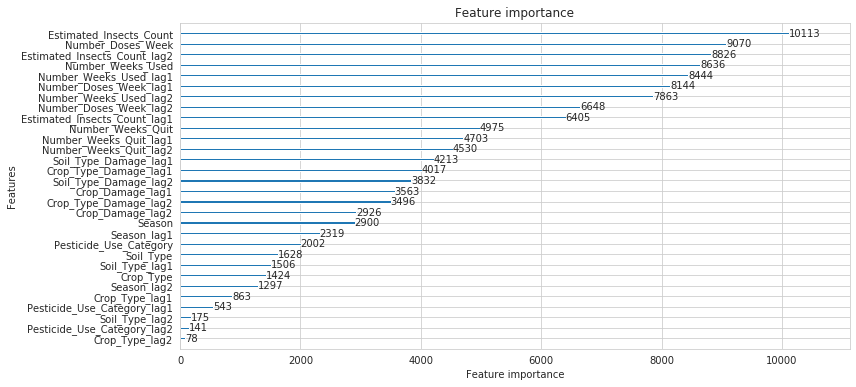

In [92]:
plt.rcParams['figure.figsize'] = (12, 6)
lgb.plot_importance(clf)
plt.show()

In [93]:
submission.to_csv('lgbm.csv',index=False)